<a href="https://colab.research.google.com/github/chihina/gan-mnist-python/blob/master/simple_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train simple GAN for MNIST

### Import library


In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.utils import save_image

import random
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

##Define network

In [70]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, mnist_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(latent_dim, 256, bias=False)
        self.fc2 = torch.nn.Linear(256, 512, bias=False)
        self.fc3 = torch.nn.Linear(512, mnist_size, bias=False)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class Discriminator(torch.nn.Module):
    def __init__(self, class_num):
        super().__init__()

        self.conv_block = nn.Sequential(
             nn.Conv2d(1, 2, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.Conv2d(2, 4, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.MaxPool2d((2, 2)),
             nn.Conv2d(4, 8, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.Conv2d(8, 16, kernel_size=3, padding=1),
             nn.ReLU(),

             nn.Conv2d(16, class_num, kernel_size=1),
             nn.AvgPool2d((14, 14)),
             nn.Flatten(),
        )

        self.sigmooid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_block(x)
        x = self.sigmooid(x)

        return x

## Define train function

In [121]:
def train(epoch):
    G_losses = 0
    D_losses = 0

    netD.train()
    netG.train()

    for data in tqdm(trainloader):
        img, label_mnist = data[0], data[1]
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        img = img.to(device)
        label = label.to(device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch

        # Forward pass real batch through D
        output = netD(img).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        netD.zero_grad()
        errD_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, latent_dim, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake = fake.view(batch_size, 1, int(mnist_size**0.5), int(mnist_size**0.5))
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses += errG.item()
        D_losses += errD.item()

    G_losses_epoch = G_losses / len(trainloader)
    D_losses_epoch = D_losses / len(trainloader)

    return G_losses_epoch, D_losses_epoch

## Define valid function

In [123]:
def valid(epoch_num):
    G_losses = 0
    D_losses = 0

    netD.eval()
    netG.eval()

    for data in tqdm(trainloader):
      img, label_mnist = data[0], data[1]
      label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
      
      img = img.to(device)
      label = label.to(device)

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      ## Train with all-real batch

      # Forward pass real batch through D
      output = netD(img).view(-1)
      
      # Calculate loss on all-real batch
      errD_real = criterion(output, label)
      
      # Calculate gradients for D in backward pass
      netD.zero_grad()
      errD_real.backward()

      ## Train with all-fake batch
      
      # Generate batch of latent vectors
      noise = torch.randn(batch_size, latent_dim, device=device)
      # Generate fake image batch with G
      fake = netG(noise)
      label.fill_(fake_label)
      # Classify all fake batch with D
      fake = fake.view(batch_size, 1, int(mnist_size**0.5), int(mnist_size**0.5))
      output = netD(fake.detach()).view(-1)

      # Calculate D's loss on the all-fake batch
      errD_fake = criterion(output, label)
      # Calculate the gradients for this batch, accumulated (summed) with previous gradients
      errD_fake.backward()
      # Compute error of D as sum over the fake and the real batches
      errD = errD_real + errD_fake
      # Update D
      # optimizerD.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.zero_grad()
      label.fill_(real_label)  # fake labels are real for generator cost
      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = netD(fake).view(-1)
      # Calculate G's loss based on this output
      errG = criterion(output, label)
      # Calculate gradients for G
      errG.backward()
      D_G_z2 = output.mean().item()
      # Update G
      # optimizerG.step()

      # Save Losses for plotting later
      G_losses += errG.item()
      D_losses += errD.item()

    G_losses_epoch = G_losses / len(trainloader)
    D_losses_epoch = D_losses / len(trainloader)

    return G_losses_epoch, D_losses_epoch

## Run training and validation

In [124]:
# seed
torch.manual_seed(777)

# define parameters
latent_dim = 64
mnist_size = 28 * 28
batch_size = 32
lr = 0.001
epoch_all = 20

# for gpu
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# generate model instances
netD = Discriminator(1)
netG = Generator(latent_dim, mnist_size)

# move to GPU
netD = netD.to(device)
netG = netG.to(device)

# Setup Adam optimizers for generator and discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

# Initialize CrossEntoropy function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=batch_size,
                                            shuffle=False, 
                                            num_workers=2)

G_losses_array = np.zeros((2, epoch_all))
D_losses_array = np.zeros((2, epoch_all))

best_loss = 10000

for epoch_num in range(1, epoch_all+1):

    G_losses_epoch_train, D_losses_epoch_train = train(epoch_num)
    print(f'Train, Epoch:{epoch_num}/{epoch_all}, G_loss:{G_losses_epoch_train:.5f}, D_loss:{D_losses_epoch_train:.5f}')
    
    G_losses_epoch_valid, D_losses_epoch_valid = valid(epoch_num)
    print(f'Valid, Epoch:{epoch_num}/{epoch_all}, G_loss:{G_losses_epoch_valid:.5f}, D_loss:{D_losses_epoch_valid:.5f}')

    G_losses_array[0, epoch_num-1] = G_losses_epoch_train
    D_losses_array[0, epoch_num-1] = D_losses_epoch_train
    G_losses_array[1, epoch_num-1] = G_losses_epoch_valid
    D_losses_array[1, epoch_num-1] = D_losses_epoch_valid

    valid_loss_all = G_losses_epoch_valid + D_losses_epoch_valid
    if best_loss > valid_loss_all:
      best_loss = valid_loss_all
      print(f'Best loss, save {epoch_num} epoch')
      torch.save(netD.state_dict(), 'netD_weight.pth')
      torch.save(netG.state_dict(), 'netG_weight.pth')

100%|██████████| 1875/1875 [00:50<00:00, 36.98it/s]


Train, Epoch:1/5, G_loss:1.22323, D_loss:1.27558


100%|██████████| 1875/1875 [00:41<00:00, 44.85it/s]


Valid, Epoch:1/5, G_loss:0.62513, D_loss:1.45584
Best loss, save 1 epoch


100%|██████████| 1875/1875 [00:47<00:00, 39.37it/s]


Train, Epoch:2/5, G_loss:0.69229, D_loss:1.39141


100%|██████████| 1875/1875 [00:43<00:00, 43.10it/s]


Valid, Epoch:2/5, G_loss:0.63061, D_loss:1.38497
Best loss, save 2 epoch


100%|██████████| 1875/1875 [00:47<00:00, 39.67it/s]


Train, Epoch:3/5, G_loss:0.75851, D_loss:1.36200


100%|██████████| 1875/1875 [00:42<00:00, 44.54it/s]


Valid, Epoch:3/5, G_loss:0.65892, D_loss:1.39518


100%|██████████| 1875/1875 [00:47<00:00, 39.87it/s]


Train, Epoch:4/5, G_loss:0.69249, D_loss:1.38918


100%|██████████| 1875/1875 [00:43<00:00, 42.87it/s]


Valid, Epoch:4/5, G_loss:0.67781, D_loss:1.38905


100%|██████████| 1875/1875 [00:48<00:00, 38.93it/s]


Train, Epoch:5/5, G_loss:0.69203, D_loss:1.38714


100%|██████████| 1875/1875 [00:43<00:00, 43.27it/s]

Valid, Epoch:5/5, G_loss:0.70238, D_loss:1.38677


## Visualize loss curves

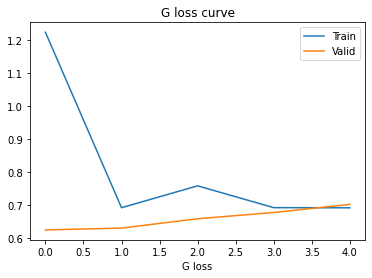

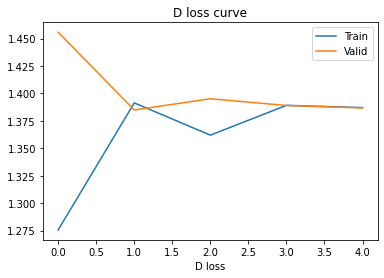

In [127]:
plt.figure()
plt.plot(np.arange(epoch_num), G_losses_array[0, :], label='Train')
plt.plot(np.arange(epoch_num), G_losses_array[1, :], label='Valid')
plt.title('G loss curve')
plt.xlabel('Epoch num')
plt.xlabel('G loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(epoch_num), D_losses_array[0, :], label='Train')
plt.plot(np.arange(epoch_num), D_losses_array[1, :], label='Valid')
plt.title('D loss curve')
plt.xlabel('Epoch num')
plt.xlabel('D loss')
plt.legend()
plt.show()

# Generate image using trained model

Random noise torch.Size([1, 64])
Generated img torch.Size([1, 1, 28, 28])


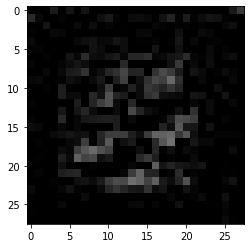

In [150]:
from PIL import Image

# generate model instances
netG = Generator(latent_dim, mnist_size)
netG.load_state_dict(torch.load('netG_weight.pth', map_location=device))

# move to GPU
netG = netG.to(device)

# generate noise sample
noise = torch.randn(1, latent_dim, device=device)
print('Random noise', noise.shape)
generated_img = netG(noise)
generated_img = generated_img.view(1, 1, int(mnist_size**0.5), int(mnist_size**0.5))
print('Generated img', generated_img.shape)

# save generated image
save_image(generated_img, f'generated_img.png')
generated_img = Image.open("generated_img.png")
generated_img = np.asarray(generated_img)
plt.imshow(generated_img)
plt.show()